Decision Tree - Accuracy: 0.896875, ROC AUC: 0.8502644614222148
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       277
           1       0.60      0.72      0.65        43

    accuracy                           0.90       320
   macro avg       0.78      0.82      0.80       320
weighted avg       0.91      0.90      0.90       320



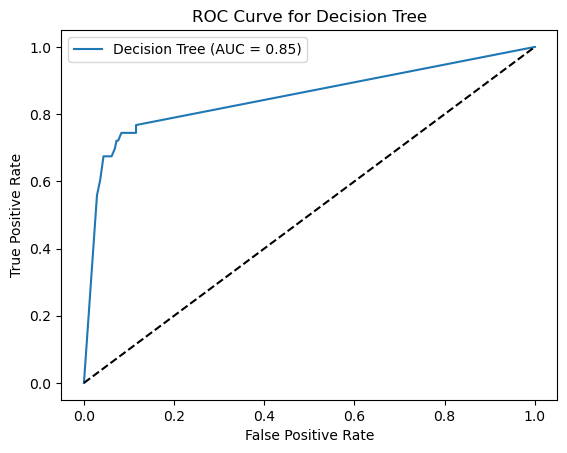

Random Forest - Accuracy: 0.9375, ROC AUC: 0.9469398035429435
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       277
           1       0.93      0.58      0.71        43

    accuracy                           0.94       320
   macro avg       0.93      0.79      0.84       320
weighted avg       0.94      0.94      0.93       320



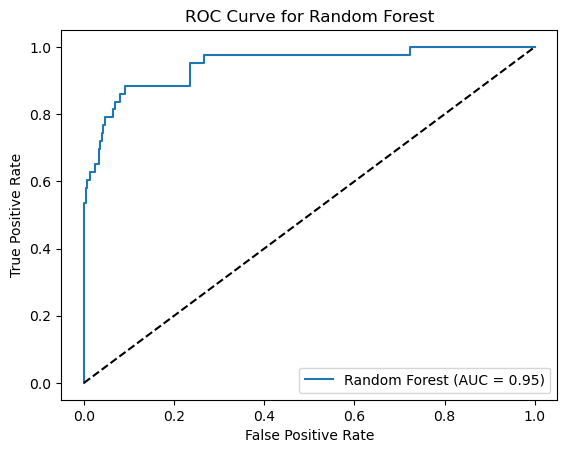

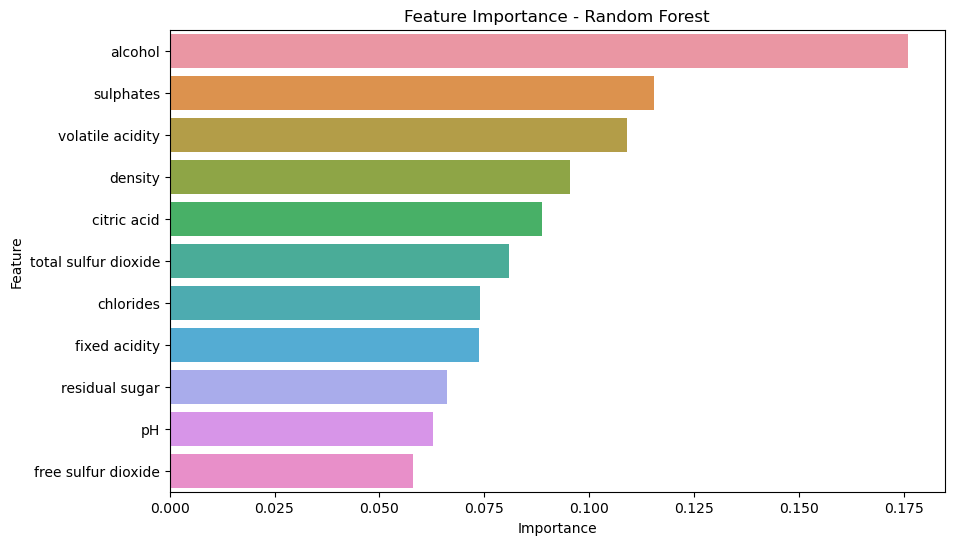

['best_rf_model.pkl']

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
url = 'https://github.com/FlipRoboTechnologies/ML-Datasets/blob/main/Red%20Wine/winequality-red.csv?raw=true'
data = pd.read_csv(url)

# Data Preprocessing
# Convert quality to binary classification
data['quality'] = np.where(data['quality'] >= 7, 1, 0)

# Separate features and target
X = data.drop('quality', axis=1)
y = data['quality']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Model Building
# Initialize models
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)

# Hyperparameter tuning for Decision Tree
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_dt = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
grid_search_dt.fit(X_train, y_train)

# Best Decision Tree model
best_dt = grid_search_dt.best_estimator_

# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, n_jobs=-1, scoring='roc_auc')
grid_search_rf.fit(X_train, y_train)

# Best Random Forest model
best_rf = grid_search_rf.best_estimator_

# Model Evaluation
models = {
    'Decision Tree': best_dt,
    'Random Forest': best_rf
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f'{name} - Accuracy: {accuracy}, ROC AUC: {roc_auc}')
    print(classification_report(y_test, y_pred))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {name}')
    plt.legend(loc='best')
    plt.show()

# Feature Importance for Random Forest
feature_importances = best_rf.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance - Random Forest')
plt.show()

# Save the best model
import joblib
joblib.dump(best_rf, 'best_rf_model.pkl')